In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [2]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 656 items
Length of Scanned Items is 1349 items
Length of Scanned Items is 2014 items
Length of Scanned Items is 2687 items
Length of Scanned Items is 3132 items
Elapsed time: 0 minutes, 15 seconds


## Expected Energy Demand, Duration

In [3]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [4]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [5]:

optimizer_time = pd.Timestamp(2023, 2, 7, 8)
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

,connectTime,choice,power,endTime,Duration,userId,Deadline,startChargeTime,DurationHrs,dcosId,lastUpdate
939,2023-02-07 08:32:19,REGULAR,"[{'power_W': 6736, 'timestamp': 1675812017}]",2023-02-07 15:20:17,0 days 06:47:48,792,NaT,2023-02-07 08:32:29,6.79666,4150,2023-02-07 15:20:17
2300,2023-02-07 08:39:32,REGULAR,"[{'power_W': 6682, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 05:03:48,1233,NaT,2023-02-07 08:41:21,5.06333,4151,2023-02-07 13:45:09
1773,2023-02-07 09:02:28,SCHEDULED,"[{'power_W': 4497, 'timestamp': 1675810509}]",2023-02-07 14:55:09,0 days 05:51:44,1126,2023-02-07 15:00:00,2023-02-07 09:03:25,5.86222,4153,2023-02-07 14:55:09
1383,2023-02-07 09:19:18,REGULAR,"[{'power_W': 3576, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 04:24:03,988,NaT,2023-02-07 09:21:06,4.40083,4154,2023-02-07 13:45:09
1975,2023-02-07 09:50:38,REGULAR,"[{'power_W': 6624, 'timestamp': 1675809308}]",2023-02-07 14:35:08,0 days 04:44:16,1149,NaT,2023-02-07 09:50:52,4.73777,4155,2023-02-07 14:35:08
...,...,...,...,...,...,...,...,...,...,...,...
1384,2023-02-21 08:06:06,REGULAR,"[{'power_W': 6728, 'timestamp': 1677003615}, {...",2023-02-21 11:30:17,0 days 03:22:33,988,NaT,2023-02-21 08:07:44,3.37583,4294,2023-02-21 11:30:17
722,2023-02-21 08:08:46,REGULAR,"[{'power_W': 8, 'timestamp': 1677003615}, {'po...",2023-02-21 16:05:08,0 days 07:54:20,691,NaT,2023-02-21 08:10:48,7.90555,4295,2023-02-21 16:05:08
2097,2023-02-21 10:58:39,REGULAR,"[{'power_W': 0, 'timestamp': 1677006009}, {'po...",2023-02-21 17:40:08,0 days 06:41:06,1165,NaT,2023-02-21 10:59:02,6.68499,4297,2023-02-21 17:40:08
1978,2023-02-21 14:49:26,REGULAR,"[{'power_W': 0, 'timestamp': 1677019808}, {'po...",2023-02-21 19:05:08,0 days 04:15:32,1149,NaT,2023-02-21 14:49:36,4.25888,4298,2023-02-21 19:05:08


In [6]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [7]:
plt.rcParams['figure.dpi'] =300

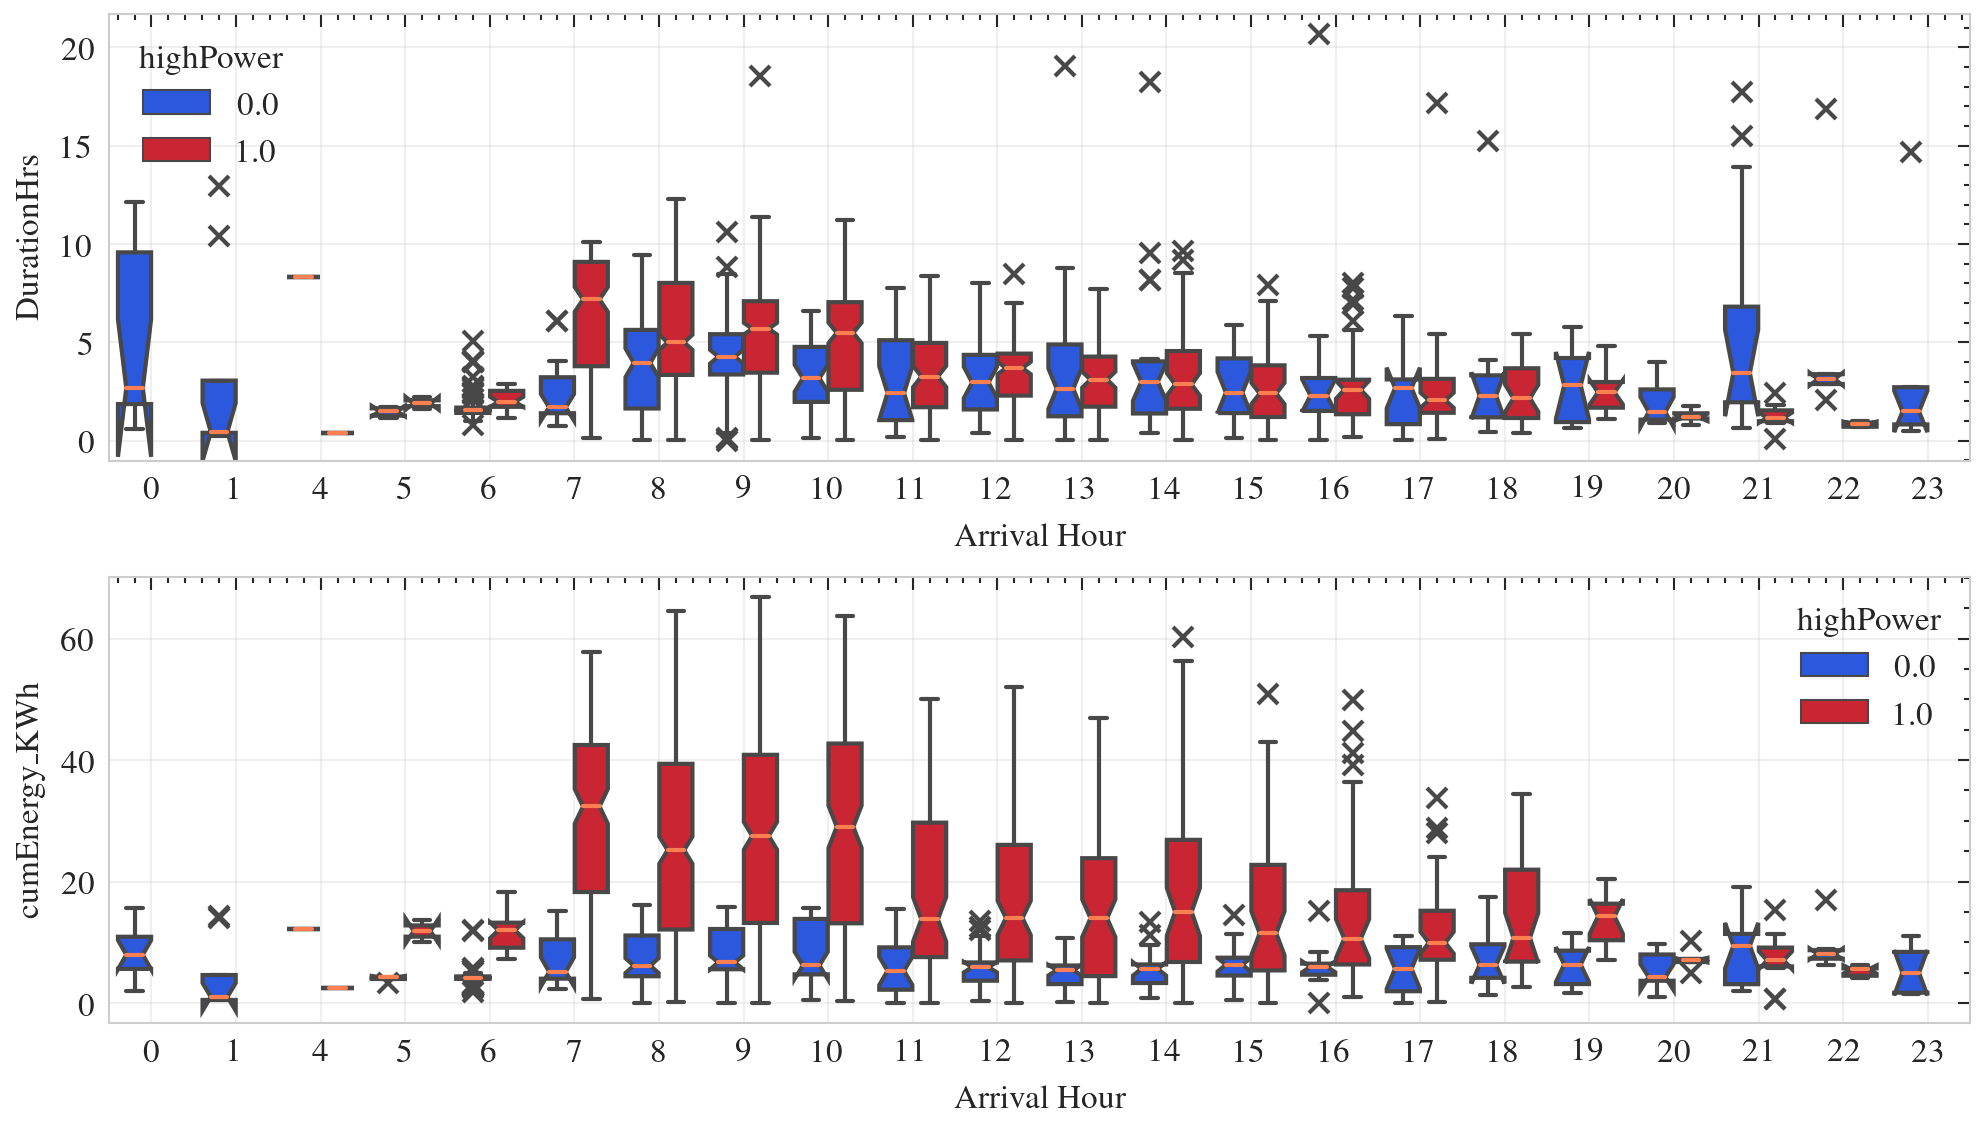

In [8]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))



sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")



In [10]:
expected_demand['count'].fillna(0,inplace=True)
expected_demand.fillna(method='bfill',inplace=True) # ffill previously, now change to bfill

In [17]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand.rename(columns = {'cumEnergy_Wh':"estEnergyWh", 
                                  'cumEnergy_KWh':"estEnergykWh", 
                                  "DurationHrs":"estDurationHrs"},inplace=True)

In [18]:
expected_demand

,highPower,arrHour,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count
0,0,0,5.115760,8349.500000,533.111111,8.349500,3.3,12.0
1,0,1,3.232010,4157.500000,379.047917,4.157500,3.3,8.0
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0
5,0,5,1.465440,3995.000000,1003.226667,3.995000,3.3,5.0
6,0,6,1.637458,4215.265306,993.837483,4.215265,3.3,245.0
7,0,7,2.484269,7079.333333,813.412037,7.079333,3.3,18.0
8,0,8,4.005247,7516.594595,361.381081,7.516595,3.3,74.0
9,0,9,4.323759,8331.211765,230.774510,8.331212,3.3,85.0


# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



Questions(Yifei):
1. What if the count of corresponding arrival hour/power level is NaN?
2. How can I retrieve the power profile of ongoing sessions?(from this dataframe? How to store the station info / define an object?)
3. Charging profile for the last control interval(only charge fractions).

In [12]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh

TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


In [13]:
%%time
## Task 1: Run for 24 hours with no on going sessions 

expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['sch_expected_power_W'] = pd.Series()
expected_demand['reg_expected_power_W'] = pd.Series()

#### TODO: YIFEI RUN OPTIMIZER FOR THE EACH ROW IN THIS DATAFRAME WITH 0 DEMAND CHARGE PENALTY ####
# ASSUME NO VEHICLES
# DON'T USE SINGLE CHARGER, ONLY USE STATION LEVEL OPTIMIZER
# When recording the powers use the same format in the sessions.csv

## Yifei: Should these parameters be fixed in the optimizer(inside) or given under different scenarios(outside the optimizer)?
par = opt.Parameters(z0 = np.array([20, 20, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff)

for row in range(len(expected_demand)):

    if expected_demand.loc[row, 'estDurationHrs'] > 0:
        try:
            arrival_hour = expected_demand.loc[row, 'arrHour']
            duration_hour = expected_demand.loc[row, 'estDurationHrs']
            e_need = expected_demand.loc[row, 'estEnergykWh']

            ### Yifei: Also do we define the event here or in the optimizer?
            event = {
                "time": int(arrival_hour / delta_t),
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[row, 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0
            }

            prb = opt.Problem(par=par, event=event)

            # Yifei: The station object, here we assume no ongoing sessions. The form of this object is not decided yet. Dict or Class?
            station = {}
            station['FLEX_list'] = list()
            station['ASAP_list'] = list()

            obj = opt.Optimization_station(par, prb, station, arrival_hour)
            station, res = obj.run_opt()
            # obj = opt.Optimization_charger(par, prb)
            # res = obj.run_opt()

            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

            expected_demand.loc[row, 'sch_centsPerHr'] = sch_centsPerHr 
            expected_demand.loc[row, 'reg_centsPerHr'] = reg_centsPerHr 
            expected_demand.loc[row, 'sch_expected_power_W' ] = json.dumps(list(res["sch_powers"].flatten()))
            expected_demand.loc[row, 'reg_expected_power_W' ] = json.dumps(list(res["reg_powers"].flatten()))
            # expected_demand.loc[row, 'sch_expected_power_W'] = sch_expected_power_W
            # expected_demand.loc[row, 'reg_expected_power_W'] = reg_expected_power_W
        except AssertionError:
            print("Error:",row)
    else:
        expected_demand.loc[row, 'sch_centsPerHr'] = 0
        expected_demand.loc[row, 'reg_centsPerHr'] = 0
        # expected_demand.loc[row, 'sch_expected_power_W'] = 0
        # expected_demand.loc[row, 'reg_expected_power_W'] = 0

After 9 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.336768 20.229853
After 9 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.336771 20.229851
After 6 iterations, we got -0.102123  improvements, and claim convergence.
The prices are 19.893188 20.448783
After 11 iterations, we got -0.075708  improvements, and claim convergence.
The prices are 20.194670 21.404079
After 9 iterations, we got -0.449644  improvements, and claim convergence.
The prices are 20.410568 21.911441
After 9 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.337628 20.230519
After 9 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.336831 20.229874
After 2 iterations, we got -0.002376  improvements, and claim convergence.
The prices are 19.992360 19.996485
After 4 iterations, we got -0.300325  improvements, and claim convergence.
The prices are 19.938195 20.343422
After 17 iter

TypeError: 'NoneType' object is not subscriptable

In [18]:
expected_demand

,highPower,arrHour,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count
0,0,0,5.115760,8349.500000,533.111111,8.349500,3.3,12.0
1,0,1,3.232010,4157.500000,379.047917,4.157500,3.3,8.0
2,0,2,8.323880,12213.000000,704.250000,12.213000,3.3,0.0
3,0,3,8.323880,12213.000000,704.250000,12.213000,3.3,0.0
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0
5,0,5,1.465440,3995.000000,1003.226667,3.995000,3.3,5.0
6,0,6,1.637458,4215.265306,993.837483,4.215265,3.3,245.0
7,0,7,2.484269,7079.333333,813.412037,7.079333,3.3,18.0
8,0,8,4.005247,7516.594595,361.381081,7.516595,3.3,74.0
9,0,9,4.323759,8331.211765,230.774510,8.331212,3.3,85.0


In [ ]:
high_TOU = TOU_tariff * 6.6
low_TOU = TOU_tariff * 3.3

# Plot initial guess vs optimization result 
fig,axes= plt.subplots(2,1,figsize=(w * 2 ,h*2))
# Objective Value for each iteration 
ax=axes[0]
arrHour = expected_demand[expected_demand['highPower']==0]['arrHour'].values

expected_demand['reg_centsPerHr'].values
expected_demand['sch_centsPerHr'].values

ax.plot(arrHour, expected_demand[expected_demand['highPower']==0]['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, expected_demand[expected_demand['highPower']==0]['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(0,180)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("Low Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)


ax=axes[1]
arrHour = expected_demand[expected_demand['highPower']==1]['arrHour'].values

expected_demand['reg_centsPerHr'].values
expected_demand['sch_centsPerHr'].values

ax.plot(arrHour, expected_demand[expected_demand['highPower']==1]['sch_centsPerHr'].values, 
        label = 'SCHEDULED Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, expected_demand[expected_demand['highPower']==1]['reg_centsPerHr'].values, color=high_vis_map[4], label = 'REGULAR Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), low_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(0,180)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

# fig.savefig('Figures/fig2a.pdf', dpi=300)

# Plot Powers

In [ ]:
import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

In [ ]:
#### RECORD AND CHECK ALL HOURS MAYBE PUT THEM IN A GOOGLE SLIDES. COMMENT ON THE RESULTS. LABEL THE PROBLEM CASES IF ANY. 
steps_in_hr = 4
eff = 1 
interval_size_minutes = int(60 * delta_t)
assert steps_in_hr == int(1/delta_t)

arrival_hour = 20
arrHour = arrival_hour
station_pow_max = 6.6
interval_size_hour = 0.25

high_powers = expected_demand[(expected_demand['highPower']==1)].set_index('arrHour')

power = np.array(json.loads(high_powers.loc[arrival_hour,'sch_expected_power_W']))
e_need = high_powers.loc[arrival_hour ,"estEnergykWh"]
duration = high_powers.loc[arrival_hour ,"estDurationHrs"]

arrival_interval = int(arrival_hour *steps_in_hr)
duration_interval =  int(duration * 60 / interval_size_minutes)

###### HAVE THE SAME DISCRETIZATION HERE IN THE OPTIMIZER ############################
N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1


try:
    sch_arr = np.zeros((96,1))
    reg_arr = np.zeros((96,1))  
    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(interval_size_minutes ))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
    if N_asap_remainder > 0:
        reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder

except: 
    timerange = pd.date_range("1/1/2021", periods=96 * 2, freq="{}min".format(interval_size_minutes))
    sch_arr = np.zeros((96*2,1))
    reg_arr = np.zeros((96*2,1))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder
    high_TOU = np.concatenate([high_TOU,high_TOU])


fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

ax1.plot(timerange, reg_arr, label = "Regular Charging, Delivered Energy: "+str(np.round(np.sum(reg_arr * 0.25),2)))
ax = ax1.twinx()
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")

reg_price_cents_hour = high_powers.loc[arrHour,'reg_centsPerHr']
ax.axhline(reg_price_cents_hour  ,linestyle='--',color='red', 
           label = reg_price_cents_hour)
ax.legend(loc=3)


ax2.plot(timerange, sch_arr, label = "Scheduled Charging, Delivered Energy: "+str(np.round(np.sum(sch_arr * 0.25),2)))
ax = ax2.twinx()

sch_price_cents_hour = high_powers.loc[arrHour,'sch_centsPerHr']


ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red', 
           label =sch_price_cents_hour)
ax.legend(loc=3)
plot_arrival_departure([ax1,ax2], arrival_hour, 0, int(arrival_hour + duration), 
                       int(60 * ((arrival_hour + duration) % int(arrival_hour + duration))))

# plot_max_min_power([ax1,ax2],6.6)
for ax in [ax1,ax2]:
    ax.set_ylim(-0.5,7)
    ax.legend(loc=0)
    ax.legend(loc=0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (kW)")


fig.suptitle("Arrival Hour {}".format(arrival_hour))

In [ ]:
arrival_hours = [7, 8, 9, 13, 14, 15, 19, 20]

for arrival_hour in arrival_hours:
    steps_in_hr = 4
    eff = 1 
    interval_size_minutes = int(60 * delta_t)
    assert steps_in_hr == int(1/delta_t)

    arrHour = arrival_hour
    station_pow_max = 3.3
    interval_size_hour = 0.25

    high_powers = expected_demand[(expected_demand['highPower']==0)].set_index('arrHour')

    power = np.array(json.loads(high_powers.loc[arrival_hour,'sch_expected_power_W']))
    e_need = high_powers.loc[arrival_hour ,"estEnergykWh"]
    duration = high_powers.loc[arrival_hour ,"estDurationHrs"]

    arrival_interval = int(arrival_hour *steps_in_hr)
    duration_interval =  int(duration * 60 / interval_size_minutes)

    ###### HAVE THE SAME DISCRETIZATION HERE IN THE OPTIMIZER ############################
    N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
    N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1


    try:
        sch_arr = np.zeros((96,1))
        reg_arr = np.zeros((96,1))  
        timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(interval_size_minutes ))
        sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
        reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
        if N_asap_remainder > 0:
            reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder

    except: 
        timerange = pd.date_range("1/1/2021", periods=96 * 2, freq="{}min".format(interval_size_minutes))
        sch_arr = np.zeros((96*2,1))
        reg_arr = np.zeros((96*2,1))
        sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
        reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
        reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder
        high_TOU = np.concatenate([high_TOU,high_TOU])


    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

    ax1.plot(timerange, reg_arr, label = "Regular Charging, Delivered Energy: "+str(np.round(np.sum(reg_arr * 0.25),2)))
    ax = ax1.twinx()
    ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")

    reg_price_cents_hour = high_powers.loc[arrHour,'reg_centsPerHr']
    ax.axhline(reg_price_cents_hour  ,linestyle='--',color='red', 
            label = reg_price_cents_hour)
    ax.legend(loc=3)


    ax2.plot(timerange, sch_arr, label = "Scheduled Charging, Delivered Energy: "+str(np.round(np.sum(sch_arr * 0.25),2)))
    ax = ax2.twinx()

    sch_price_cents_hour = high_powers.loc[arrHour,'sch_centsPerHr']


    ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
    ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red', 
            label =sch_price_cents_hour)
    ax.legend(loc=3)
    plot_arrival_departure([ax1,ax2], arrival_hour, 0, int(arrival_hour + duration), 
                        int(60 * ((arrival_hour + duration) % int(arrival_hour + duration))))

    # plot_max_min_power([ax1,ax2],6.6)
    for ax in [ax1,ax2]:
        ax.set_ylim(-0.5,7)
        ax.legend(loc=0)
        ax.legend(loc=0)
        ax.set_xlabel("Time")
        ax.set_ylabel("Power (kW)")


    fig.suptitle("Arrival Hour {}".format(arrival_hour))

# Test Case: With pricing constraints reg_price \leq sch_price

In [ ]:
%%time
## Task 1: Run for 24 hours with no on going sessions

expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['sch_expected_power_W'] = pd.Series()
expected_demand['reg_expected_power_W'] = pd.Series()

#### TODO: YIFEI RUN OPTIMIZER FOR THE EACH ROW IN THIS DATAFRAME WITH 0 DEMAND CHARGE PENALTY ####
# ASSUME NO VEHICLES
# DON'T USE SINGLE CHARGER, ONLY USE STATION LEVEL OPTIMIZER
# When recording the powers use the same format in the sessions.csv

par = opt.Parameters(z0 = np.array([20, 20, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff)

for row in range(len(expected_demand)):

    if expected_demand.loc[row, 'estDurationHrs'] > 0:
        try:
            arrival_hour = expected_demand.loc[row, 'arrHour']
            duration_hour = expected_demand.loc[row, 'estDurationHrs']
            e_need = expected_demand.loc[row, 'estEnergykWh']

            event = {
                "time": int(arrival_hour / delta_t),
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[row, 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": True,
                "sch_limit": 20
            }

            prb = opt.Problem(par=par, event=event)

            station = {}
            station['FLEX_list'] = list()
            station['ASAP_list'] = list()

            obj = opt.Optimization_station(par, prb, station, arrival_hour)
            station, res = obj.run_opt()

            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

            expected_demand.loc[row, 'sch_centsPerHr'] = sch_centsPerHr
            expected_demand.loc[row, 'reg_centsPerHr'] = reg_centsPerHr
            expected_demand.loc[row, 'sch_expected_power_W' ] = json.dumps(list(res["sch_powers"].flatten()))
            expected_demand.loc[row, 'reg_expected_power_W' ] = json.dumps(list(res["reg_powers"].flatten()))
        except AssertionError:
            print("Error:",row)
    else:
        expected_demand.loc[row, 'sch_centsPerHr'] = 0
        expected_demand.loc[row, 'reg_centsPerHr'] = 0

In [ ]:
## Task 2: Run for 4 hours after a new vehicle arrives
######### Vehicle chooses REGULAR 

optimizer_time = pd.Timestamp(2023, 2, 7, 8)
print("Current time of the optimizer:",optimizer_time)

# find on-going sessions  --> This is not the best 

print("On-going sessions:",
      len(session_df[(session_df['endTime']>optimizer_time) & 
                     (session_df['startChargeTime']<optimizer_time)]))

#### TODO: YIFEI RUN OPTIMIZER FOR THE NEXT 4 HOURS #### 
SESSION_1 = session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime').iloc[0]

## VEHICLE CHOOSES REGULAR
## RECORD THE REGULAR POWER PROFILE 
# session_df.loc[SESSIONS_IDX,'opt_power_W'] = pd.Series()


## Run optimization again 
### FIll price and power column ### 
expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['expected_power_W'] = pd.Series()

In [ ]:
session_df.loc[2289,'power']